In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# Create engine using the hawaii.sqlite database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
session

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)

In [11]:
inspector.get_table_names()

['measurement', 'station']

In [12]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
#engine.execute('SELECT * FROM measurement').fetchall()

In [15]:
# Total dates
session.query(func.count(Measurement.date)).all()

[(19550)]

In [16]:
# Earliest Date
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [17]:
# Latest Date
query_2_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

date_2 = dt.datetime.strptime(query_2_date[0],'%Y-%m-%d')
# date truncation
date_2 = dt.date(date_2.year, date_2.month, date_2.day)

print("Query Last Date: ", date_2)

Query Last Date:  2017-08-23


In [18]:
# Calculate the date 1 year ago from the last data point in the database
query_1_date = ((date_2) - dt.timedelta(days=1* 365))
date_1 = query_1_date
print("Query First Date: ", date_1)

Query First Date:  2016-08-23


In [19]:
# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date.label('date'), (Measurement.prcp).label('prcp')).\
    filter(Measurement.date >= date_1).all() 
    #group_by('prcp').\
    #order_by('date').
data

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06'

In [20]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df1 = pd.DataFrame(data)
df1.set_index('date', inplace=True)
df1.sort_values(by=['date'])
df1.dropna
df1.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


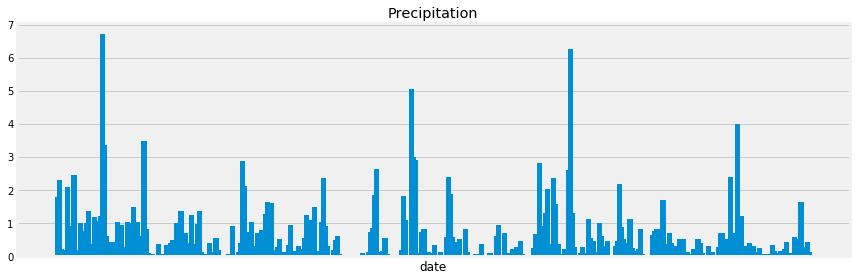

In [21]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(12,4))
ax.bar(df1.index, df1.prcp, width= 2.5)
ax.set_xlabel("date")
ax.set_xticks([])
ax.set_title("Precipitation")
fig.tight_layout()

plt.savefig("Preciptation vs Date")
plt.show()


In [22]:
# Use Pandas to calcualte the summary statistics for the precipitation data
stats = df1.prcp.describe()
stats
df2 = pd.DataFrame(stats)
df2.rename(columns={'prcp': 'precipitation'}, inplace=True)
df2.head(10)


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [23]:
# Design a query to show how many stations are available in this dataset?
no_stations = session.query(Station).distinct(Station.name).count()
print(f"The number of stations is: {no_stations}")

The number of stations is: 9


In [24]:
#Identify the most active station by plotting the frequence of occurrences.
AS = session.query(Measurement.station, func.count(Measurement.station).label('freq')).\
                    group_by(Measurement.station).\
                    order_by('freq DESC')

df = pd.read_sql(AS.statement, AS.session.bind)
df

C:\Users\User\AppData\Local\Programs\Python\Python36\lib\site-packages\sqlalchemy\sql\compiler.py:763: SAWarning: Can't resolve label reference 'freq DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element),


,station,freq
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [25]:
st_id = df.iloc[0,0]
print(f"The most active station is {st_id}")

The most active station is USC00519281


In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

Temps = session.query(Measurement.station.label('Station'), \
                      func.min(Measurement.tobs).label('Min_Temp'), \
                      func.max(Measurement.tobs).label('Max_Temp'), \
                      func.avg(Measurement.tobs).label('Avg_Temp')). \
                      filter(Measurement.station == str(st_id))

df = pd.read_sql(Temps.statement, Temps.session.bind)
df

,Station,Min_Temp,Max_Temp,Avg_Temp
0,USC00519281,54.0,85.0,71.663781


In [27]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
# and plot the results as a histogram

Histo = session.query((Measurement.date).label('Date'), \
                      (Measurement.tobs).label('Temp')). \
                      filter(Measurement.station == str(st_id)).\
                      filter(Measurement.date >= date_1)

hist1 = pd.read_sql(Histo.statement, Histo.session.bind)
hist1.head()

,Date,Temp
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


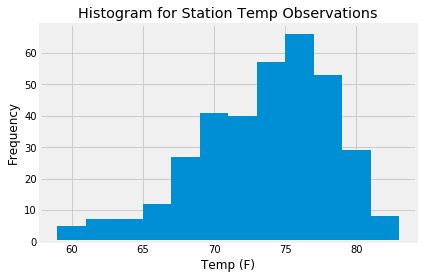

In [28]:
plt.hist(hist1['Temp'],bins=12);
plt.xlabel('Temp (F)')
plt.ylabel('Frequency')
plt.title('Histogram for Station Temp Observations')
plt.savefig("Histogram for Station Temp Observations")
plt.show()

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [30]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip =(calc_temps('2017-02-15', '2017-02-25'))
trip

[(61.0, 70.66666666666667, 77.0)]

In [31]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# The actual vacation dates are 15feb to 25Feb 2017.
# v_dates are the dates for the previous year's temperature averages.

v_date1 = dt.datetime(2017,2,15) - dt.timedelta(days=1* 365)
v_date2 = dt.datetime(2017,2,25) - dt.timedelta(days=1* 365)

sel = [func.max(Measurement.tobs).label('max_temp'), 
       func.min(Measurement.tobs).label('min_temp'), 
       func.avg(Measurement.tobs).label('avg_temp')] 

Temps = session.query(*sel).\
    filter(Measurement.date >= v_date1).\
    filter(Measurement.date <= v_date2).all()

Temp_df = pd.DataFrame(Temps)
Temp_df

,max_temp,min_temp,avg_temp
0,77.0,60.0,69.907692


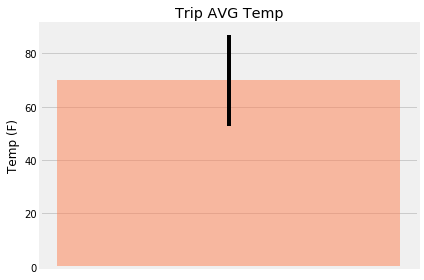

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

avgtemp = Temp_df.iloc[:,2]
min_temp = Temp_df.iloc[:,1]
max_temp = Temp_df.iloc[:,0]
tmax_tmin = Temp_df.iloc[:,0] - Temp_df.iloc[:,1]

plt.bar(0, avgtemp, yerr=tmax_tmin, color='coral', alpha=0.5, width =0.1)
plt.xticks(np.arange(0.1, 0.1))
plt.ylabel('Temp (F)')
plt.title('Trip AVG Temp')
plt.tight_layout()
plt.savefig("Trip Average Temps")
plt.show()

In [33]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
#date1 = dt.datetime(2017,2,15)
#date2 = dt.datetime(2017,2,25)

v_date1 = dt.datetime(2017,2,15) - dt.timedelta(days=1* 365)
v_date2 = dt.datetime(2017,2,25) - dt.timedelta(days=1* 365)

def Rainfall(start_date, end_date):           
         
            start_date = v_date1
            end_date = v_date2
            
            
            sel = [Measurement.station,
                    Station.name,
                    Station.latitude,
                    Station.longitude,
                    Station.elevation,
                    func.sum(Measurement.prcp).label('Total_Precipitation')]

            Rain = session.query(*sel).\
                filter(Measurement.station == Station.station).\
                filter(Measurement.date >= start_date).\
                filter(Measurement.date <= end_date).\
                group_by(Measurement.station).\
                order_by('Total_Precipitation DESC').all()

            
            df7 = pd.DataFrame(Rain)
        
            return df7

In [34]:
Rainfall('2017-03-15', '2017-03-25')

C:\Users\User\AppData\Local\Programs\Python\Python36\lib\site-packages\sqlalchemy\sql\compiler.py:763: SAWarning: Can't resolve label reference 'Total_Precipitation DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element),


,station,name,latitude,longitude,elevation,Total_Precipitation
0,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.82
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.72
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.67
3,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.61
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.48
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.27
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


## Optional Challenge Assignment

In [35]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month 
# and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("02-02")


[(59.0, 68.85964912280701, 77.0)]

In [36]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
date1 = dt.datetime(2017,2,15)
date2 = dt.datetime(2017,2,25)

# Use the start and end date to create a range of dates

dates = session.query(Measurement.date.label('date')).\
                filter(Measurement.date >= date1).\
                filter(Measurement.date <= date2).\
                group_by(Measurement.date).all()

dates = list(np.ravel(dates))


In [37]:
dates

['2017-02-16',
 '2017-02-17',
 '2017-02-18',
 '2017-02-19',
 '2017-02-20',
 '2017-02-21',
 '2017-02-22',
 '2017-02-23',
 '2017-02-24',
 '2017-02-25']

In [38]:
m_d_dates = [dt.datetime.strptime(ymd, '%Y-%m-%d').strftime('%m-%d') for ymd in dates]
m_d_dates

['02-16',
 '02-17',
 '02-18',
 '02-19',
 '02-20',
 '02-21',
 '02-22',
 '02-23',
 '02-24',
 '02-25']

In [39]:
d1= pd.DataFrame(m_d_dates)
d1

,0
0,02-16
1,02-17
2,02-18
3,02-19
4,02-20
5,02-21
6,02-22
7,02-23
8,02-24
9,02-25


In [40]:
new_data1 = []
for date in m_d_dates:
    sel = [func.min(Measurement.tobs).label('min'), func.avg(Measurement.tobs).label('Avg'), func.max(Measurement.tobs).label('max')]
    new_data = session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    new_data1.append(new_data)
    
new_data1

[[(59.0, 70.48214285714286, 76.0)],
 [(62.0, 70.47272727272727, 77.0)],
 [(63.0, 70.79629629629629, 77.0)],
 [(60.0, 69.33962264150944, 77.0)],
 [(63.0, 70.14035087719299, 76.0)],
 [(63.0, 69.79629629629629, 76.0)],
 [(60.0, 70.15789473684211, 83.0)],
 [(62.0, 70.35593220338983, 81.0)],
 [(61.0, 68.56666666666666, 76.0)],
 [(61.0, 68.59649122807018, 76.0)]]

In [41]:
df = pd.DataFrame(new_data1)
df

,0
0,"(59.0, 70.48214285714286, 76.0)"
1,"(62.0, 70.47272727272727, 77.0)"
2,"(63.0, 70.79629629629629, 77.0)"
3,"(60.0, 69.33962264150944, 77.0)"
4,"(63.0, 70.14035087719299, 76.0)"
5,"(63.0, 69.79629629629629, 76.0)"
6,"(60.0, 70.15789473684211, 83.0)"
7,"(62.0, 70.35593220338983, 81.0)"
8,"(61.0, 68.56666666666666, 76.0)"
9,"(61.0, 68.59649122807018, 76.0)"


In [42]:
df2 = pd.DataFrame(df[0].values.tolist(), columns=['min','avg','max'])
df3 = pd.DataFrame(df2)
df3

,min,avg,max
0,59.0,70.482143,76.0
1,62.0,70.472727,77.0
2,63.0,70.796296,77.0
3,60.0,69.339623,77.0
4,63.0,70.140351,76.0
5,63.0,69.796296,76.0
6,60.0,70.157895,83.0
7,62.0,70.355932,81.0
8,61.0,68.566667,76.0
9,61.0,68.596491,76.0


In [43]:
df_new = pd.concat([d1, df3],axis=1)
df_new.set_index(0)

,min,avg,max
0,,,
02-16,59.0,70.482143,76.0
02-17,62.0,70.472727,77.0
02-18,63.0,70.796296,77.0
02-19,60.0,69.339623,77.0
02-20,63.0,70.140351,76.0
02-21,63.0,69.796296,76.0
02-22,60.0,70.157895,83.0
02-23,62.0,70.355932,81.0
02-24,61.0,68.566667,76.0


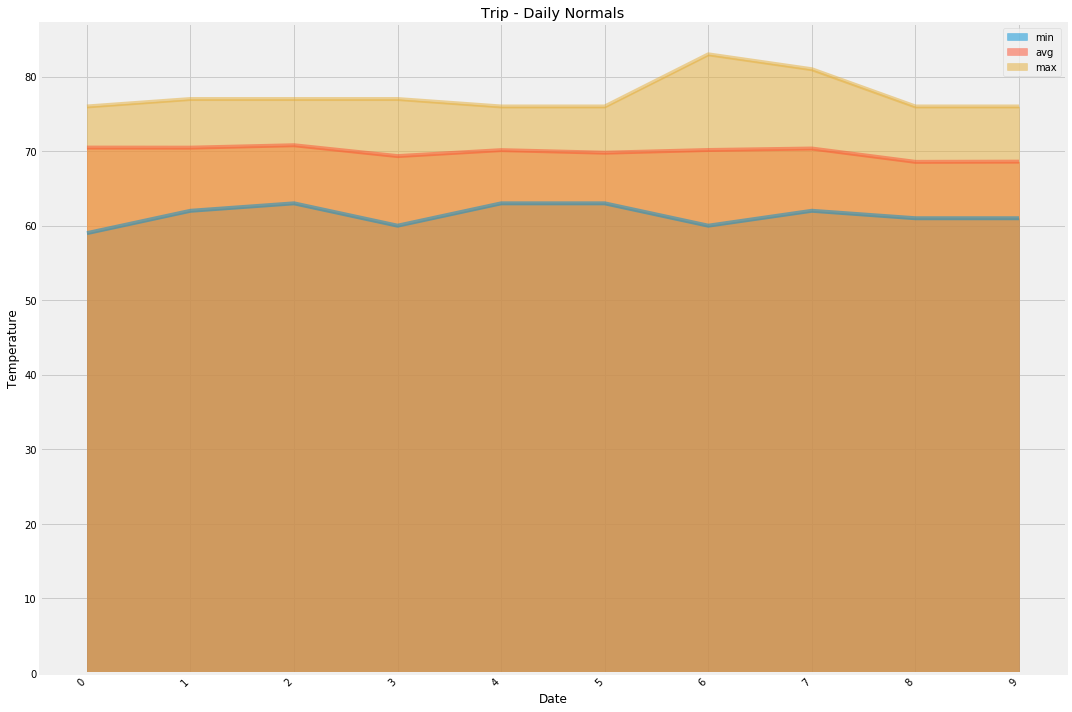

In [44]:
df_new.plot(kind='area',stacked=False,figsize=(15,10))
plt.xticks(df_new.index, rotation=45, ha="right")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title(f"Trip - Daily Normals")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Daily Normal Temps for Trip Range")
plt.show()